### Todo
* Dropout
* L2 loss
* Momentum
* RMSProp
* Adam
* Check if grads are locked before update
* public interface
* derivs in constructor
* mean

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils
import time

import nn_framework as nn
from nn_framework.gradient_check import gradient_check
from nn_framework.optimizers import GradientDescentOptimizer, MomentumOptimizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def dense(X, input_dim, output_dim):
  W = nn.variable(np.random.randn(output_dim, input_dim))
  b = nn.variable(np.zeros([output_dim, 1]))
  return W @ X + b

X.shape = (2, 1000), Y.shape = (1, 1000)


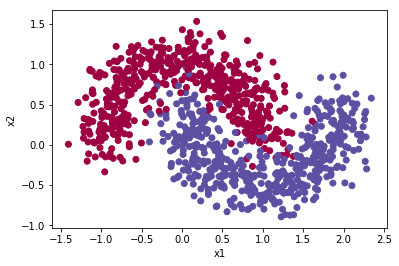

In [3]:
m = 1000
X, Y = sklearn.datasets.make_moons(m, noise=0.2)
X = X.T
Y = Y.reshape(-1, 1).T

print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [4]:
def compare(a, b):
  return np.linalg.norm(a - b) / (np.linalg.norm(a) + np.linalg.norm(b))

tf.reset_default_graph()
m = 1000
n = 20
n_h = 50

w = np.random.randn(n_h, n)
b = np.random.randn(n_h, 1)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
biastf = tf.constant(b)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf) + biastf ** 2
ztf *= ztf
[dwtf, dbtf] = tf.gradients(ztf, [wtf, biastf])

# My :D
wmy = nn.variable(w)
biasmy = nn.variable(b)
amy = wmy * nn.const(2)
amy *= amy
bmy = (nn.const(t1) @ wmy @ nn.const(t2) + nn.const(1)) * nn.const(2) - nn.const(3)
bmy *= bmy

zmy = amy @ bmy + biasmy ** nn.const(2)
zmy *= zmy
dwmy, dbmy = zmy.deriv(wmy, nn.ones(zmy.shape)), zmy.deriv(biasmy, nn.ones(zmy.shape))

with tf.Session() as sess:
  [dwtf_val, dbtf_val] = sess.run([dwtf, dbtf])
  [dwmy_val, dbmy_val] = nn.Session().run([dwmy, dbmy], {})
  
  assert dwtf_val.shape == dwmy_val.shape, 'dw shapes should match'
  assert dbtf_val.shape == dbmy_val.shape, 'db shapes should match'
  
  dw_mse = compare(dwtf_val, dwmy_val)
  db_mse = compare(dbtf_val, dbmy_val)
  
  print('actual test: dw mse: %s, db mse: %s' % (dw_mse, db_mse))

actual test: dw mse: 2.55407440769e-16, db mse: 2.53295962661e-16


2.33528080933e-08
step: 0, loss: 1.057895, accuracy: 55.1
step: 200, loss: 0.281676, accuracy: 87.9
step: 400, loss: 0.268328, accuracy: 87.9
step: 600, loss: 0.253180, accuracy: 89.1
step: 800, loss: 0.237811, accuracy: 90.1
step: 1000, loss: 0.219043, accuracy: 91.1
step: 1200, loss: 0.197661, accuracy: 92.4
step: 1400, loss: 0.174811, accuracy: 94.1
step: 1600, loss: 0.155642, accuracy: 94.8
step: 1800, loss: 0.140985, accuracy: 95.6
step: 2000, loss: 0.129475, accuracy: 95.9
step: 2200, loss: 0.120417, accuracy: 96.2
step: 2400, loss: 0.113437, accuracy: 96.3
step: 2600, loss: 0.107859, accuracy: 96.5
step: 2800, loss: 0.103448, accuracy: 96.7
9.342983961105347


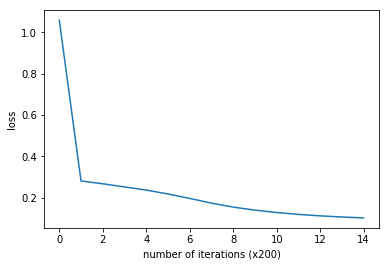

In [5]:
# var = Variable(np.random.randn(2, 3))
# tmp = nn.mean(var)
# dvar = tmp.deriv(var, Ones(tmp.shape))
# sess = Session()
# print(sess.run([var]))
# print(sess.run([tmp]))
# print(sess.run([dvar]))
# fail

learning_rate = nn.const(0.1)
steps = 3000
log_interval = 200

assert X.shape[0] == 2

A0 = nn.placeholder('X', [X.shape[0], None])
net = A0
net = dense(net, input_dim=2, output_dim=16)
net = nn.relu(net)
net = dense(net, input_dim=16, output_dim=1)  
net = nn.sigmoid(net)
Y_hat = net

loss = nn.mean(nn.logistic_loss(a=Y_hat, y=nn.const(Y)))
print(gradient_check(loss, {A0: X}))
global_step = nn.variable(0)

# train = GradientDescentOptimizer(loss, learning_rate, global_step)
train = MomentumOptimizer(loss, learning_rate, global_step)
losses = []

sess = nn.Session()

t = time.time()
for i in range(0, steps):
  _, l, Y_hat_val = sess.run([train, loss, Y_hat], {A0: X})
  
  if i % log_interval == 0:
    acc = np.mean(Y == (Y_hat_val > 0.5)) * 100
    print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))
    losses.append(l)
print(time.time() - t)
    
plt.plot(losses)
plt.xlabel('number of iterations (x%s)' % log_interval)
plt.ylabel('loss')

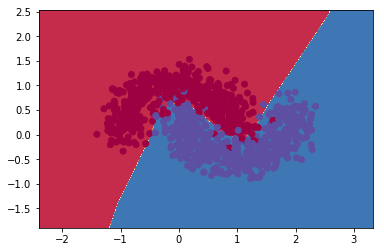

In [6]:
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T})[0] > 0.5, X, Y, cmap=plt.cm.Spectral)